In [37]:
%run -m ipy_startup
%matplotlib inline
%load_ext rpy2.ipython
from ml import query
from pbto2 import data, prep

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [38]:
# Good results:

# max_hours = 48
# time = 'tsi_min'
# pbto2_thresh = .25
# agg_mode = 'pct'
# pbto2_bins = [0, 20, 100, np.inf]
# pao2_bins = [0, 300, 800, np.inf]
# interp = '4'
# allow_gos_interp = True

# max_hours = 48
# time = 'tsi_min'
# pbto2_thresh = 8 / max_hours
# agg_mode = 'pct'
# pbto2_bins = [0, 20, 100, np.inf]
# pao2_bins = [0, 30, 100, np.inf]
# interp = 'none'
# allow_gos_interp = True

In [ ]:
# config_name = 'config1'
# max_hours = 48
# time = 'tsi_min'
# pbto2_thresh = 8 / max_hours
# agg_mode = 'pct'
# pbto2_bins = [0, 20, 100, np.inf]
# pao2_bins = [0, 30, 100, np.inf]
# icp_bins = [0, 20, np.inf]
# pha_bins = [0, 7.35, 7.45, np.inf]
# paco2_bins = [0, 35, 45, np.inf]
# interp = 'all'
# allow_gos_interp = True

In [49]:
config_name = 'config2'
max_hours = 48
time = 'tsi_min'
pbto2_thresh = 8 / max_hours
agg_mode = 'pct'
pbto2_bins = [0, 20, 100, np.inf]
pao2_bins = [0, 30, 100, np.inf]
icp_bins = [0, 20, np.inf]
pha_bins = [0, 7.35, 7.45, np.inf]
paco2_bins = [0, 35, 45, np.inf]
interp = 'none'
allow_gos_interp = True

d = data.get_raw_data(f='data_clean_interp_{}.pkl'.format(interp))

# Multiply pao2 values by constant
d['pao2'] = d['pao2'] * .4

# This patient has an excessively long string of consecutive 0 pbto2 values after this tsa_min value
# (so remove the unnecessary measurements)
d = d[(d['uid'] != 1001) | (d['tsa_min'] <= 1320)]

def plot_ts(d, col, uids, figsize=(12,6), ylim=None):
    df = d[d['uid'].isin(uids)][['tsa_min', col, 'uid']]
    ax = df.pivot_table(index='tsa_min', columns='uid', values=col).plot(figsize=figsize)
    if ylim is not None:
        ax.set_ylim(ylim)
        
# Limit to only some subset of early measurments
d = d[d[time] <= max_hours * 60]

# Remove patients that don't have enough measurments within the early subset
ct = d.groupby('uid').apply(lambda x: len(x['pbto2'].dropna()) / max_hours)
#ct.hist()
rm_uids = ct[ct < pbto2_thresh].index.values
d = d[~d['uid'].isin(rm_uids)]

# Set gos response column, using interpolation if enabled
if allow_gos_interp:
    d['gos'] = d.apply(lambda x: x['gos-3'] if not pd.isnull(x['gos-3']) else x['gos-6'], axis=1)
else:
    d['gos'] = d['gos-3']

In [50]:
#d.paco2.hist(bins=50)

In [51]:
# uids = d[d['pbto2'] <= 0].groupby('uid').size()
# uids = uids[uids > 6].index.values
# plot_ts(d, 'pbto2', uids)

In [52]:
# uids = d['uid'].unique()
# uids = uids[np.random.permutation(np.arange(len(uids)))[:10]]
# plot_ts(d, 'pao2', uids)

In [53]:
def get_features(x):
    def bin_values(v, bins, prefix, mode='count'):
        assert mode in ['count', 'mean', 'pct'], 'Mode {} is not valid'.format(mode)
        labels = ['{}_{}_{}'.format(prefix, bins[i-1], bins[i]) for i in range(1, len(bins))]
        ct = pd.cut(v, bins=bins, include_lowest=True, right=False, labels=labels)
        if mode == 'count':
            ct = ct.value_counts()
        elif mode == 'pct':
            ct = ct.value_counts()
            ct = ct if ct.sum() == 0 else ct / ct.sum()
        elif mode == 'mean':
            ct = v.groupby(ct).mean()
        return ct.to_dict()
    
    r = {}
    r.update(bin_values(x['pbto2'], pbto2_bins, 'pbto2', mode=agg_mode))
    r.update(bin_values(x['pao2'], pao2_bins, 'pao2', mode=agg_mode))
    r.update(bin_values(x['icp1'], icp_bins, 'icp1', mode=agg_mode))
    r.update(bin_values(x['pha'], pha_bins, 'pha', mode=agg_mode))
    r.update(bin_values(x['paco2'], paco2_bins, 'paco2', mode=agg_mode))
#     r['n_pbto2'] = len(x['pbto2'].dropna())
#     r['n_pao2'] = len(x['pao2'].dropna())
#     r['n_icp1'] = len(x['icp1'].dropna())
#     r['n_pha'] = len(x['pha'].dropna())
#     r['n_paco2'] = len(x['paco2'].dropna())
        
    x = x.iloc[0]
    r['gos'] = x['gos']
    r['marshall'] = x['marshall']
    r['gcs'] = x['gcs']
    r['age'] = x['age']
    r['sex'] = x['sex']
    
    return pd.Series(r)
do = d.groupby('uid').apply(get_features)
do = do[~do['gos'].isnull()]
do = do[~do['marshall'].isnull()]
do.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 461 to 1056
Data columns (total 19 columns):
age              263 non-null float64
gcs              263 non-null float64
gos              263 non-null float64
icp1_0_20        263 non-null float64
icp1_20_inf      263 non-null float64
marshall         263 non-null float64
paco2_0_35       263 non-null float64
paco2_35_45      263 non-null float64
paco2_45_inf     263 non-null float64
pao2_0_30        263 non-null float64
pao2_100_inf     263 non-null float64
pao2_30_100      263 non-null float64
pbto2_0_20       263 non-null float64
pbto2_100_inf    263 non-null float64
pbto2_20_100     263 non-null float64
pha_0_7.35       263 non-null float64
pha_7.35_7.45    263 non-null float64
pha_7.45_inf     263 non-null float64
sex              263 non-null float64
dtypes: float64(19)
memory usage: 41.1 KB


# Exports

In [54]:
config = {
    'max_hours': max_hours, 'pbto2_thresh': pbto2_thresh, 'agg_mode': agg_mode,
    'ts_interp': interp, 'gos_interp': allow_gos_interp
}
export_dir = '/Users/eczech/data/pbto2/final/{}'.format(config_name)
import os
if not os.path.exists(export_dir):
    os.mkdir(export_dir)

In [55]:
# Save data in wide format
do.reset_index().to_csv('{}/data_wide.csv'.format(export_dir), index=False)

In [56]:
# Save data in long format
d_exp = d[d['uid'].isin(do.index.values)]
d_exp.to_csv('{}/data_long.csv'.format(export_dir), index=False)

In [57]:
d_exp[d_exp['pbto2'].isnull()]

,pbto2,pao2,pha,icp1,paco2,map,uid,datetime,bo2,birthdate,...,tsi,tsa,tsi_min,tsa_min,marshall,gos-12,gos-24,gos-3,gos-6,gos
23671,NaN,NaN,NaN,NaN,NaN,NaN,534,2003-08-27 11:00:00,31.4,1978-05-14,...,13:00:00,0 days,780,0,2,3,NaN,3,3,3


# Modeling

In [58]:
#do.plot(kind='scatter', x='n_pbto2', y='gos')

In [60]:
%%R -i do
library(dplyr)
library(MASS)
scale <- function(x) (x - mean(x)) / sd(x)
d <- do %>% mutate_each(funs(as.numeric)) %>%
    mutate_each(funs(scale), -gos) %>%
    #dplyr::select(-pao2_300_800, -pbto2_20_100, -starts_with('n_'), -starts_with('pao2'))
    dplyr::select(-paco2_35_45, -icp1_0_20, -pha_7.35_7.45, -pao2_30_100, -pbto2_20_100, -starts_with('n_'))

In [76]:
%%R 
res <- d %>% mutate(gos = ifelse(gos <= 3, 0, 1)) %>%
    glm(gos ~ ., data=., family='binomial')
    #glm(gos ~ age + sex + marshall + gcs + pbto2_0_20 + pbto2_100_inf, data=., family='binomial')
    #glm(gos ~ age + sex + marshall + gcs + icp1_20_inf, data=., family='binomial')
    #glm(gos ~ age + sex + marshall + gcs + pao2_0_30, data=., family='binomial')
    #glm(gos ~ age + sex + marshall + gcs + paco2_45_inf, data=., family='binomial')
summary(res)


Call:
glm(formula = gos ~ ., family = "binomial", data = .)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7271  -0.7224  -0.4305   0.3773   2.7564  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.54132    0.20578  -7.490 6.87e-14 ***
age           -0.70317    0.20402  -3.447 0.000568 ***
gcs            0.52774    0.18797   2.808 0.004991 ** 
icp1_20_inf   -0.60068    0.31090  -1.932 0.053348 .  
marshall      -0.36173    0.19847  -1.823 0.068368 .  
paco2_0_35    -0.04247    0.20178  -0.211 0.833277    
paco2_45_inf   0.58806    0.21606   2.722 0.006494 ** 
pao2_0_30     -0.47814    0.20851  -2.293 0.021842 *  
pao2_100_inf  -0.16213    0.17549  -0.924 0.355544    
pbto2_0_20    -0.33005    0.18370  -1.797 0.072395 .  
pbto2_100_inf -0.78856    0.42386  -1.860 0.062823 .  
pha_0_7.35    -0.33376    0.22364  -1.492 0.135598    
pha_7.45_inf  -0.35273    0.21635  -1.630 0.103034    
sex            0.23948    0.19463   1.23

In [63]:
%%R
get.polr.coefs <- function(m){
    coefs <- coef(summary(m))
    p <- pnorm(abs(coefs[, "t value"]), lower.tail = FALSE) * 2
    coefs <- cbind(coefs, "p value" = p)
    coefs
}
m <- d %>% 
    mutate(gos=factor(gos, levels=1:5, labels=c('Dead', 'Bad1', 'Bad2', 'Good1', 'Good2'))) %>%
    polr(gos ~ ., data = ., Hess=TRUE)
print(summary(m))
get.polr.coefs(m)

Call:
polr(formula = gos ~ ., data = ., Hess = TRUE)

Coefficients:
                 Value Std. Error t value
age           -0.97370     0.1498 -6.5013
gcs            0.71987     0.1362  5.2867
icp1_20_inf   -0.49453     0.1702 -2.9063
marshall      -0.31493     0.1394 -2.2587
paco2_0_35    -0.09577     0.1399 -0.6846
paco2_45_inf   0.52909     0.1565  3.3810
pao2_0_30     -0.25299     0.1218 -2.0764
pao2_100_inf  -0.25201     0.1288 -1.9573
pbto2_0_20    -0.20411     0.1287 -1.5861
pbto2_100_inf -0.07631     0.1230 -0.6204
pha_0_7.35    -0.23234     0.1558 -1.4915
pha_7.45_inf  -0.23581     0.1443 -1.6343
sex            0.14677     0.1308  1.1224

Intercepts:
            Value   Std. Error t value
Dead|Bad1   -1.4042  0.1725    -8.1411
Bad1|Bad2   -1.0709  0.1626    -6.5874
Bad2|Good1   1.5994  0.1785     8.9619
Good1|Good2  3.7722  0.3217    11.7247

Residual Deviance: 574.8123 
AIC: 608.8123 
                    Value Std. Error    t value      p value
age           -0.97369683  0.1

In [64]:
%%R
m <- d %>% 
    mutate(gos=ifelse(gos==1, 0, ifelse(gos <= 3, 1, 2))) %>%
    mutate(gos=factor(gos, levels=1:3, labels=c('Dead', 'Bad', 'Good'))) %>%
    polr(gos ~ ., data = ., Hess=TRUE)
print(summary(m))
get.polr.coefs(m)

Call:
polr(formula = gos ~ ., data = ., Hess = TRUE)

Coefficients:
                 Value Std. Error t value
age           -0.38884     0.2226 -1.7464
gcs            0.33599     0.1945  1.7273
icp1_20_inf   -0.55354     0.3287 -1.6839
marshall      -0.35211     0.2020 -1.7431
paco2_0_35    -0.07918     0.2155 -0.3674
paco2_45_inf   0.47491     0.2275  2.0877
pao2_0_30     -0.50257     0.2112 -2.3793
pao2_100_inf  -0.06852     0.1837 -0.3730
pbto2_0_20    -0.31826     0.1932 -1.6475
pbto2_100_inf -0.75666     0.4291 -1.7633
pha_0_7.35    -0.24683     0.2421 -1.0195
pha_7.45_inf  -0.30188     0.2195 -1.3752
sex            0.22092     0.2006  1.1013

Intercepts:
         Value    Std. Error t value 
Dead|Bad   1.1509   0.2193     5.2481
Bad|Good  61.7721   0.2193   281.6788

Residual Deviance: 214.8865 
AIC: 244.8865 
(68 observations deleted due to missingness)
                    Value Std. Error     t value      p value
age           -0.38883942  0.2226494  -1.7464201 8.073799e-02
gcs

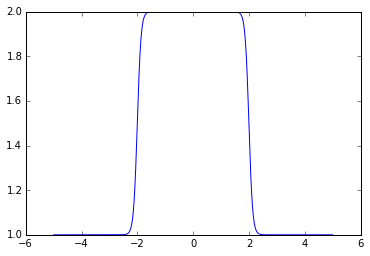

In [4]:
import math
x = np.linspace(-5, 5, 1000)

a1, a2 = 1, 1
b1, b2 = -15, 15
c1, c2 = -2, 2
def f1(x):
    return a1 / (1 + np.exp(b1*(x - c1)))
def f2(x):
    return a2 / (1 + np.exp(b2*(x - c2)))
fl1 = np.vectorize(f1)
fl2 = np.vectorize(f2)

y = (fl1(x) + fl2(x))
#y = .5 * fl1(x)
plt.plot(x, y)